# Check sync process

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datetime
import pathlib
import numpy as np
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal as sp


from u19_pipeline.ephys_pipeline import ephys_element, probe_element, get_session_directory, get_ephys_root_data_dir
import u19_pipeline.utils.ephys_fix_sync_code as ephys_fix_sync_code
import u19_pipeline.acquisition as acquisition
import datajoint as dj

from element_interface.utils import find_full_path

import u19_pipeline.utils.DemoReadSGLXData.readSGLX as readSGLX
import u19_pipeline.utils.ephys_utils as ephys_utils


[2026-02-12 18:07:34,195][INFO]: DataJoint 0.14.4 connected to alvaros@datajoint00.pni.princeton.edu:3306


In [3]:
recording_query = "recording_id = 502"
recording = dj.create_virtual_module('recording', 'u19_recording')
recording_key = (recording.Recording & recording_query).fetch('recording_id', as_dict=True, order_by='recording_id')


key = (recording.Recording.BehaviorSession & recording_query).fetch1()
del key['recording_id']

key

{'subject_fullname': 'jyanar_ya054',
 'session_date': datetime.date(2025, 10, 10),
 'session_number': 0}

In [5]:
session_dir = pathlib.Path(get_session_directory(recording_key[0]))
session_dir


PosixPath('jyanar/jyanar_ya054/20251010_g0/ya054_20251010_g0')

In [6]:
session_dir = find_full_path(get_ephys_root_data_dir(),
                            get_session_directory(recording_key))
print(session_dir)
#session_dir = pathlib.Path('/Users/alvaros/Documents/MATLAB/BrainCogsProjects/CalciumImagingData/test_g0/')
#Check if session is Nidq or OneBox
nidq_session = list(session_dir.glob('*nidq.bin*'))
obx_session = list(session_dir.glob('*obx.bin*'))

if len(nidq_session) == 0 and len(obx_session) == 0:
    print('No session found')
elif len(nidq_session) > 0:
    ephys_session_fullpath = nidq_session[0]
else:
    ephys_session_fullpath = obx_session[0]

#Nidaq file
nidq_meta          = readSGLX.readMeta(ephys_session_fullpath)
nidq_sampling_rate = readSGLX.SampRate(nidq_meta)


# 1: load meta data, and the content of the NIDAQ file. Its content is digital.            
new_trial_channel = 1
new_iteration_channel = 2
# If PXIe card (nidq) card use for recording deduce digital channels
if nidq_meta['typeThis'] == 'nidq':
    digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta)
# If onebox card (obx) card use for recording digital channels are 0-2
else:
    digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta, d_line_list=[0,1])
    # If no sync pulse found trial and iteration signals are 0 & 1 respectively
    channel0_pulses = np.where(np.diff(digital_array[0])==1)[0].shape[0]
    channel1_pulses = np.where(np.diff(digital_array[1])==1)[0].shape[0]

    if channel0_pulses > channel1_pulses:
        new_trial_channel = 1
        new_iteration_channel = 0
    else:
        new_trial_channel = 0
        new_iteration_channel = 1

/mnt/cup/braininit/Data/Raw/electrophysiology/jyanar/jyanar_ya054/20251010_g0/ya054_20251010_g0
nChan: 4, nFileSamp: 118289333


# Synchronize ePhys and Behavior

Populate the tables, using the nidaq file produced by spikeGLX. This is done automatically and produces a record of VR iteration numbers measured in the time of the ePhys setup.

### Read nidaq file and behavior data

In [7]:
#Behavior data
behavior_key = key.copy()
behavior = dj.create_virtual_module('behavior', 'u19_behavior')

block = 0
# If a specific block is requested, add that to our behavior_key. It should be an int referring to virmen block number.
# This is useful for sessions in which the nidaq stream was interrupted due to restarting virmen
if block > 0:
    behavior_key['block'] = block

thissession = behavior.TowersBlock().Trial() & behavior_key
behavior_time, iterstart, beh_num_iterations = thissession.fetch('trial_time', 'vi_start', 'iterations')


In [8]:
#plt.plot(np.diff(digital_array[new_trial_channel,:5000000]))
#plt.plot(digital_array[new_trial_channel,:5000000])


### Get samples and times where trials and iterations start

In [9]:
mode = None   #Default for sessions before 12/01/2021
#mode = 'pulses'    #Default for sessions after 12/01/2021
iteration_dict = ephys_utils.get_iteration_sample_vector_from_digital_lines_pulses(digital_array[new_trial_channel,:], digital_array[new_iteration_channel,:], nidq_sampling_rate, behavior_time.shape[0], behavior_time, mode=mode)
#                             get_iteration_sample_vector_from_digital_lines_pulses(trial_pulse_signal, iteration_pulse_signal,


# Check # of trials and iterations match
trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small = ephys_utils.assert_iteration_samples_count(iteration_dict['iter_start_idx'], behavior_time)

print(trial_count_diff)
print(trials_diff_iteration_big)
print(trials_diff_iteration_small)


status = ephys_utils.evaluate_sync_process(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small,  behavior_time.shape[0])


len trial_start_idx (309,)
mode deduction:  pulse_signal
trial# 2 iterPulses: 526 IterBeh: 527 Difference ( 1 )
trial# 3 iterPulses: 460 IterBeh: 525 Difference ( 65 )
trial# 4 iterPulses: 496 IterBeh: 497 Difference ( 1 )
trial# 13 iterPulses: 542 IterBeh: 543 Difference ( 1 )
trial# 15 iterPulses: 532 IterBeh: 533 Difference ( 1 )
trial# 22 iterPulses: 625 IterBeh: 626 Difference ( 1 )
trial# 26 iterPulses: 497 IterBeh: 498 Difference ( 1 )
trial# 27 iterPulses: 962 IterBeh: 965 Difference ( 3 )
trial# 28 iterPulses: 1117 IterBeh: 1118 Difference ( 1 )
trial# 32 iterPulses: 934 IterBeh: 935 Difference ( 1 )
trial# 33 iterPulses: 487 IterBeh: 488 Difference ( 1 )
trial# 35 iterPulses: 560 IterBeh: 561 Difference ( 1 )
trial# 36 iterPulses: 516 IterBeh: 517 Difference ( 1 )
trial# 40 iterPulses: 473 IterBeh: 474 Difference ( 1 )
trial# 51 iterPulses: 511 IterBeh: 512 Difference ( 1 )
trial# 60 iterPulses: 550 IterBeh: 551 Difference ( 1 )
trial# 69 iterPulses: 473 IterBeh: 474 Differen

In [10]:
trial_fix = 3
synced_iteration_vector = iteration_dict['iter_start_idx'][trial_fix]
synced_time_vector = (iteration_dict['iter_times_idx'][trial_fix]).copy()

behavior_time_vector = behavior_time[trial_fix].flatten()

synced_time_vector += behavior_time_vector[1]
old_synced_time_vector = (synced_time_vector).copy()

print(old_synced_time_vector[0:5])
print(behavior_time_vector[0:5])
print('--------------------')
print(np.diff(old_synced_time_vector[0:6]))
print(np.diff(behavior_time_vector[0:6]))
print(iteration_dict['iter_times_idx'][trial_fix][0:5])

[0.0177847 0.0251767 0.0326347 0.0450427 0.0617407]
[0.        0.0177847 0.0251116 0.0418594 0.0585367]
--------------------
[0.007392 0.007458 0.012408 0.016698 0.016764]
[0.0177847 0.0073269 0.0167478 0.0166773 0.0166676]
[0.       0.007392 0.01485  0.027258 0.043956]


In [11]:
behavior_time_vector.shape

(525,)

In [12]:

'''
#synced_time_vector = synced_time_vector+behavior_time_vector[1]-(behavior_time_vector[2]-synced_time_vector[2])
synced_time_vector = synced_time_vector+behavior_time_vector[1]
synced_time_vector = np.insert(synced_time_vector, 1, behavior_time_vector[1])
synced_time_vector[2:] = synced_time_vector[2:]+(behavior_time_vector[2]-synced_time_vector[2])
synced_time_vector[0] = 0

if synced_time_vector.shape[0] > behavior_time_vector.shape[0]:
    synced_time_vector = synced_time_vector[:-1]


print(synced_time_vector[0:5])
print(behavior_time_vector[0:5])
'''

'\n#synced_time_vector = synced_time_vector+behavior_time_vector[1]-(behavior_time_vector[2]-synced_time_vector[2])\nsynced_time_vector = synced_time_vector+behavior_time_vector[1]\nsynced_time_vector = np.insert(synced_time_vector, 1, behavior_time_vector[1])\nsynced_time_vector[2:] = synced_time_vector[2:]+(behavior_time_vector[2]-synced_time_vector[2])\nsynced_time_vector[0] = 0\n\nif synced_time_vector.shape[0] > behavior_time_vector.shape[0]:\n    synced_time_vector = synced_time_vector[:-1]\n\n\nprint(synced_time_vector[0:5])\nprint(behavior_time_vector[0:5])\n'

[np.float64(0.00120694746503392), np.float64(0.00820694746503392), np.float64(0.01520694746503392)]


(-0.05, 0.15)

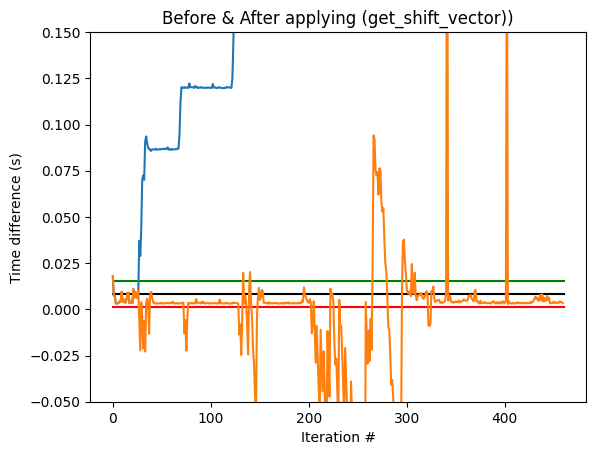

In [13]:

synced_time_vector2, shift_vec, median_vec = ephys_fix_sync_code.get_shift_vector(synced_time_vector,behavior_time_vector)

print(median_vec)



#median_diff = np.median(baseline_diff)
#max_diff = np.median(baseline_diff)+0.007
#min_diff = np.median(baseline_diff)-0.007
#time_vec = np.arange(base_size-initial_sample)
plt.plot([0, synced_time_vector.shape[0]], [median_vec[1], median_vec[1]],'k')
plt.plot([0, synced_time_vector.shape[0]], [median_vec[0], median_vec[0]],'r')
plt.plot([0, synced_time_vector.shape[0]], [median_vec[2], median_vec[2]],'g')

plt.plot(synced_time_vector - behavior_time_vector[:synced_time_vector.shape[0]])
plt.plot(synced_time_vector2 - behavior_time_vector[:synced_time_vector2.shape[0]])



plt.xlabel('Iteration #')
plt.ylabel('Time difference (s)')
plt.title('Before & After applying (get_shift_vector))')

plt.ylim([-0.05, 0.15])

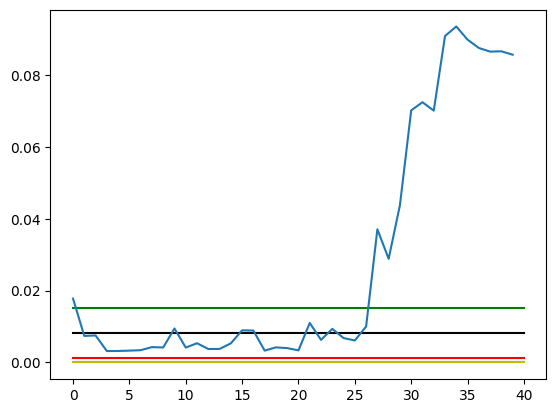

In [14]:
plt.plot([0, 40], [median_vec[1], median_vec[1]],'k')
plt.plot([0, 40], [median_vec[0], median_vec[0]],'r')
plt.plot([0, 40], [median_vec[2], median_vec[2]],'g')

plt.plot([0, 40], [0, 0],'y')

plt.plot(synced_time_vector[0:40] - behavior_time_vector[0:40])


In [15]:
trial_plot = trial_fix
samp_before = 1000
samp_after = 1600
if trial_plot == 0:
    last_iter_trial0 = iteration_dict['iter_start_idx'][trial_plot][0]-np.int64(samp_before)
else:
    last_iter_trial0 = iteration_dict['iter_start_idx'][trial_plot-1][-1]-np.int64(samp_before)
first_iter_trial1 = iteration_dict['iter_start_idx'][trial_plot][0]+np.int64(samp_after)
second_iter_trial1 = iteration_dict['iter_start_idx'][trial_plot][1]

samp_diff = iteration_dict['iter_start_idx'][trial_plot][0] - iteration_dict['iter_start_idx'][trial_plot-1][-1]
print('last_iter_trial0', last_iter_trial0)
print('first_iter_trial1', first_iter_trial1)

last_iter_trial0 2184919
first_iter_trial1 2189993


5074
samples_after_second_pulse 224
3474
new_iteration_channel 1
(118289333,)
time from niDAQ 10.897952913363554
time behavior [9.358368]
samples nidaq 330241
iter nidaq (460,)
iter_virmen (525, 1)


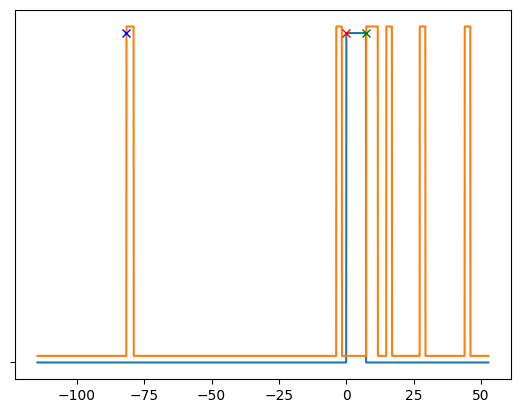

In [16]:


start_iter = 1
end_iter = 1


sample_start =(iteration_dict['iter_start_idx'][trial_plot][start_iter]-np.int64(samp_before))
sample_end = (iteration_dict['iter_start_idx'][trial_plot][end_iter]+np.int64(samp_after))

iter_sample = digital_array[new_trial_channel,last_iter_trial0:first_iter_trial1]

time_vector = np.linspace(start=0, stop=iter_sample.shape[0]-1,num=iter_sample.shape[0])
time_vector = (time_vector*1000/nidq_sampling_rate)
time_vector -=  ((iter_sample.shape[0]-samp_after)*1000)/nidq_sampling_rate

time_last_trial = time_vector[0] +(samp_before*1000)/nidq_sampling_rate



print(iter_sample.shape[0])
samples_after_second_pulse = (second_iter_trial1-(first_iter_trial1-samp_after))
print('samples_after_second_pulse', samples_after_second_pulse)
print(iter_sample.shape[0]-samp_after)

idx_time_zero = np.where((time_vector >= 0))
idx_time_zero = idx_time_zero[0]
idx_time_zero = idx_time_zero[0]


print('new_iteration_channel', new_iteration_channel)
print(digital_array[new_iteration_channel,:].shape)

plt.plot(time_vector,iter_sample)
plt.plot(time_vector,digital_array[new_iteration_channel,last_iter_trial0:first_iter_trial1]+0.02)
plt.plot(0,1,"rx",'')
if (idx_time_zero+samples_after_second_pulse) < time_vector.shape[0]:
    plt.plot(time_vector[idx_time_zero+samples_after_second_pulse],1,"gx")
plt.plot(time_last_trial,1,"bx",)

iter_nidaq = (iteration_dict['iter_start_idx'][trial_plot][-1]-iteration_dict['iter_start_idx'][trial_plot][0])
time = iter_nidaq/nidq_sampling_rate
iter_virmen = time*120

print('time from niDAQ', time)
print('time behavior', behavior_time[trial_plot][-1])

print('samples nidaq', iter_nidaq)
print('iter nidaq', iteration_dict['iter_start_idx'][trial_plot].shape)
print('iter_virmen',behavior_time[trial_plot].shape)

#plt.xlim([-20, 20])

(-0.4, 0.4)

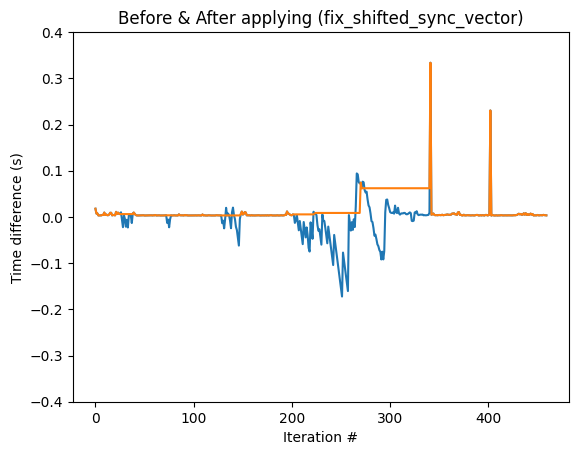

In [18]:
synced_time_vector3,_ = ephys_fix_sync_code.fix_shifted_sync_vector(synced_time_vector2, behavior_time_vector, shift_vec)

plt.plot(synced_time_vector2 - behavior_time_vector[:synced_time_vector2.shape[0]])
plt.plot(synced_time_vector3 - behavior_time_vector[:synced_time_vector3.shape[0]])


plt.xlabel('Iteration #')
plt.ylabel('Time difference (s)')
plt.title('Before & After applying (fix_shifted_sync_vector)')

plt.ylim([-0.4,0.4])



(-0.4, 0.4)

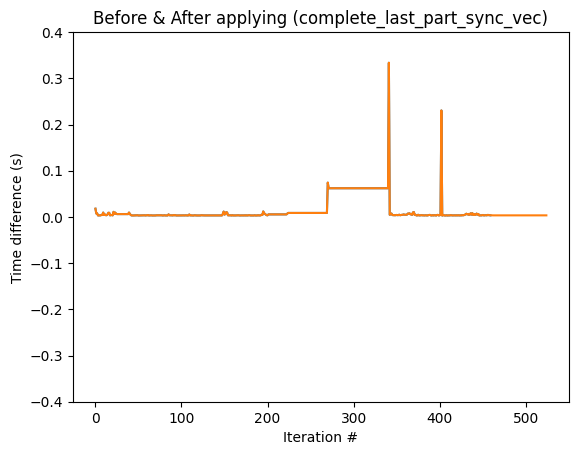

In [19]:
synced_time_vector4,_ =\
    ephys_fix_sync_code.complete_last_part_sync_vec(synced_time_vector3, behavior_time_vector)

plt.plot(synced_time_vector3 - behavior_time_vector[:synced_time_vector3.shape[0]])
plt.plot(synced_time_vector4 - behavior_time_vector[:synced_time_vector4.shape[0]])


plt.xlabel('Iteration #')
plt.ylabel('Time difference (s)')
plt.title('Before & After applying (complete_last_part_sync_vec)')

plt.ylim([-0.4, 0.4])

(-0.4, 2.2)

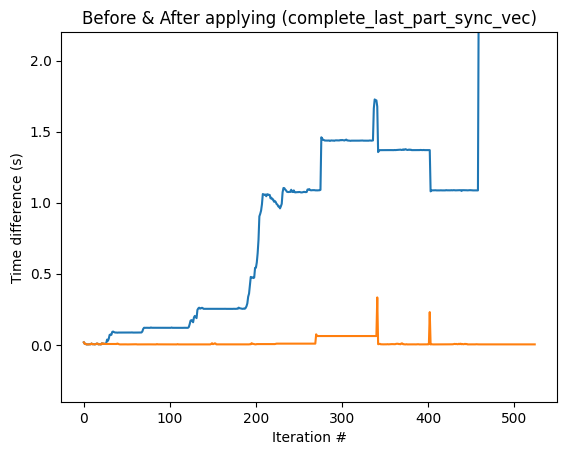

In [20]:
synced_time_vector4,_ =\
    ephys_fix_sync_code.complete_last_part_sync_vec(synced_time_vector3, behavior_time_vector)

plt.plot(synced_time_vector - behavior_time_vector[:synced_time_vector.shape[0]])
plt.plot(synced_time_vector4 - behavior_time_vector[:synced_time_vector4.shape[0]])


plt.xlabel('Iteration #')
plt.ylabel('Time difference (s)')
plt.title('Before & After applying (complete_last_part_sync_vec)')

plt.ylim([-0.4, 2.2])